In [1]:
%run 'functions_dump.py'

/Users/karen/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/karen/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
%run 'ks21_Read_impacts_of_mutations.ipynb'

11510
259

Variables: 

- fit_dict: a dictionary, keys are mutations and values are pandas.Series of fitness impacts in all backgrounds. 



In [3]:
%run 'ks20_Read_ddG.ipynb'


Variables: 
- predicted_ddG:		Pandas DataFrame with all calculated ddG (single, double and triple mutants (?)),
- predicted_doubles:		doubles only (Pandas DataFrame),
- predicted_singles:		singles only (Pandas DataFrame),
- get_ddG:			function that returns predicted ddG for a genotype
- by_position_mean_ddG:		mean ddG value at each position,
- by_position_var_ddG:		variance of predicted ddG at each position.



In [4]:
def get_neutrality(series_of_impacts, neutrality_threshold=0.4, noise_cutoff=0.01):
    negative = series_of_impacts[series_of_impacts < -1 * neutrality_threshold]
    positive = series_of_impacts[series_of_impacts > neutrality_threshold]
    neutral = series_of_impacts[(series_of_impacts < neutrality_threshold) & (series_of_impacts > -1 * neutrality_threshold)]
    fraction_negative = 1. * len(negative) / len(series_of_impacts)
    fraction_positive = 1. * len(positive) / len(series_of_impacts)
    if fraction_negative < noise_cutoff and fraction_positive < noise_cutoff:
        return 'neutral'
    if fraction_negative > noise_cutoff and fraction_positive < noise_cutoff:
        return 'negative'
    if fraction_negative < noise_cutoff and fraction_positive > noise_cutoff:
        return 'positive'
    if fraction_negative > noise_cutoff and fraction_positive > noise_cutoff:
        return 'mixed_effects'
    
def get_neutrality_percents(series_of_impacts, neutrality_threshold=0.4, noise_cutoff=0.01):
    negative = series_of_impacts[series_of_impacts < -1 * neutrality_threshold]
    positive = series_of_impacts[series_of_impacts > neutrality_threshold]
    neutral = series_of_impacts[(series_of_impacts <= neutrality_threshold) & (series_of_impacts >= -1 * neutrality_threshold)]
    fraction_negative = 1. * len(negative) / len(series_of_impacts)
    fraction_positive = 1. * len(positive) / len(series_of_impacts)
    fraction_neutral = 1. * len(neutral) / len(series_of_impacts)
    return fraction_negative, fraction_neutral, fraction_positive

In [5]:
neutrality_dict = get_fitness_summary(fit_dict, lambda series: get_neutrality_percents(series, neutrality_threshold=0.6))
neutrality = pd.Series(neutrality_dict)

predicted_singles['%_negative'] = predicted_singles['mut_list_Scer'].apply(lambda s: neutrality.loc[s][0])
predicted_singles['%_neutral'] = predicted_singles['mut_list_Scer'].apply(lambda s: neutrality.loc[s][1])
predicted_singles['%_positive'] = predicted_singles['mut_list_Scer'].apply(lambda s: neutrality.loc[s][2])

,%_negative,%_neutral,%_positive,ddG
%_negative,1.000000,-0.999971,-0.066916,0.445950
%_neutral,-0.999971,1.000000,0.063566,-0.445002
%_positive,-0.066916,0.063566,1.000000,-0.172710
ddG,0.445950,-0.445002,-0.172710,1.000000


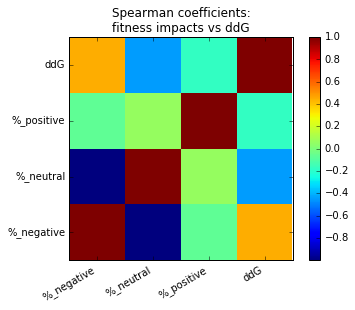

In [27]:
cols = ['%_negative', '%_neutral', '%_positive', 'ddG']
display(predicted_singles[cols].corr(method='spearman'))
plt.imshow(predicted_singles[cols].corr(method='spearman'), origin='lower', interpolation='none')
plt.colorbar()
plt.xticks(range(len(cols)), cols, rotation=30, ha='right')
plt.yticks(range(len(cols)), cols)
plt.title('Spearman coefficients:\nfitness impacts vs ddG')

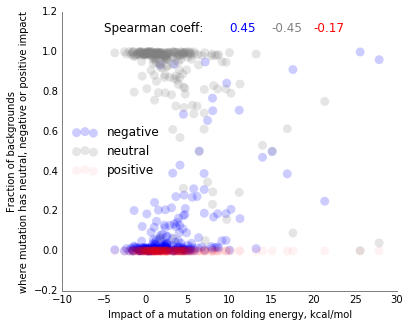

In [38]:
x, y1, y2, y3 = 'ddG', '%_negative', '%_neutral', '%_positive'
y1_color, y2_color, y3_color = 'blue', 'gray', 'red'

plot_better(width=6, height=5, grid='')
plt.scatter(predicted_singles[x], predicted_singles[y1], edgecolor='none', alpha=0.2, color=y1_color, s=80, label='negative')
plt.scatter(predicted_singles[x], predicted_singles[y2], edgecolor='none', alpha=0.2, color=y2_color, s=80, label='neutral')
plt.scatter(predicted_singles[x], predicted_singles[y3], edgecolor='none', alpha=0.05, color=y3_color, s=80, label='positive')

plt.text(-5, 1.1, 'Spearman coeff:', fontsize=12)
plt.text(10, 1.1, '%.2f' %stats.spearmanr(predicted_singles[x], predicted_singles[y1])[0], color=y1_color, fontsize=12)
plt.text(15, 1.1, '%.2f' %stats.spearmanr(predicted_singles[x], predicted_singles[y2])[0], color=y2_color, fontsize=12)
plt.text(20, 1.1, '%.2f' %stats.spearmanr(predicted_singles[x], predicted_singles[y3])[0], color=y3_color, fontsize=12)

plt.xlabel('Impact of a mutation on folding energy, kcal/mol')
plt.ylabel('Fraction of backgrounds\nwhere mutation has neutral, negative or positive impact')

plt.legend(loc='center left', frameon=False)
plt.savefig(figures_folder + 'ddG_vs_impacts.pdf')

In [58]:
def get_deviation_from_median(series):
    median = np.median(series.dropna())
    return series - median

for c in fitness_impacts.columns:
    fitness_impacts[c + '_deviation']=  get_deviation_from_median(fitness_impacts[c])

In [61]:
print np.median(fitness_impacts['106K'].dropna())

-0.0153072498375


In [74]:
def get_summary(series, function):
    return function(series.dropna())

In [84]:
merged = predicted_ddG.merge(fitness_impacts, how='left', right_index=True, left_index=True)
deviation_columns = [c for c in fitness_impacts.columns if 'deviation' in c]

In [91]:
merged['mean_deviation'] = merged[deviation_columns].apply(lambda df: get_summary(df, np.mean), axis=1)
merged['max_deviation'] = merged[deviation_columns].apply(lambda df: get_summary(df, np.max), axis=1)
merged['std_deviation'] = merged[deviation_columns].apply(lambda df: get_summary(df, np.std), axis=1)

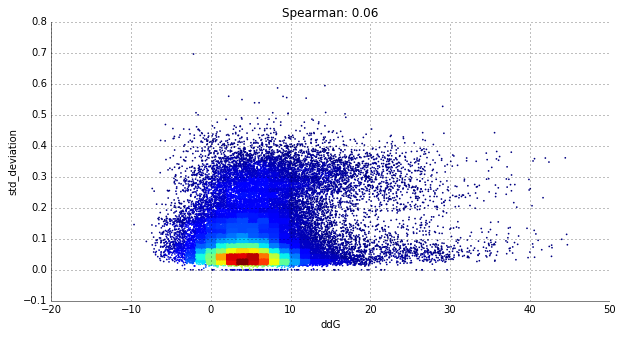

In [107]:
x = 'ddG'
y = 'std_deviation'

to_plot = merged[merged.segment != 'S9_scaled'][[x,y]].dropna()

plot_better()
density_plot(to_plot[x], to_plot[y], log=False)
plt.xlabel(x)
plt.ylabel(y)
plt.title('Spearman: %.2f' %stats.spearmanr(to_plot[x], to_plot[y])[0])

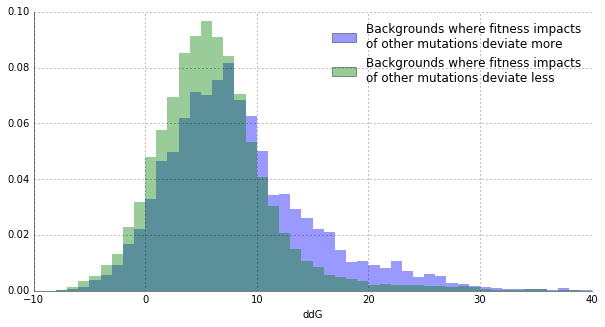

In [115]:
plot_better()
plt.hist(to_plot[to_plot.std_deviation > 0.2].ddG, alpha=0.4, normed=True, edgecolor='none', range=(-10,40), bins=50,
        label='Backgrounds where fitness impacts\nof other mutations deviate more')
plt.hist(to_plot[to_plot.std_deviation < 0.2].ddG, alpha=0.4, normed=True, edgecolor='none', range=(-10,40), bins=50,
         label='Backgrounds where fitness impacts\nof other mutations deviate less')
plt.legend(frameon=False, loc='upper right')
plt.xlabel('ddG')